In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
import pylab as pl
from IPython import display
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%matplotlib inline

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4617776738410478073
]


In [2]:
# constans
frequency = '1H'
split = 0.99
look_back = 5
look_forward = 4

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward+1): 
        dataX.append(dataset[i:(i+look_back), :])
        dataY.append(dataset[(i+look_back):(i+look_back+look_forward), 0])
    return np.array(dataX), np.array(dataY)

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

In [5]:
# load data
df_trend = pd.read_csv('trends.csv', index_col=0, header=0, skiprows=2, engine='python')
df_trend.columns = ['trend']
df_trend.index = pd.to_datetime(df_trend.index, format='%Y-%m-%d')
print(df_trend.tail(5))

df = pd.read_csv('trades.csv', index_col=0, usecols=['timestamp','price','volume', 'buysell'], header=0, engine='python')
df.index = pd.to_datetime(df.index, unit='s')
print(df.tail(5))

            trend
Week             
2017-10-01     47
2017-10-08     71
2017-10-15     75
2017-10-22     78
2017-10-29    100
                              volume   price buysell
timestamp                                           
2017-11-08 22:11:07.719500  0.050000  7300.0       s
2017-11-08 22:11:07.737400  0.325657  7336.8       b
2017-11-08 22:11:07.747800  0.325657  7336.9       b
2017-11-08 22:11:07.757200  0.243759  7345.2       b
2017-11-08 22:11:07.767100  0.104926  7346.9       b


In [6]:
# resample and extract features
one_hot = pd.get_dummies(df['buysell'])
df = df.drop('buysell', axis=1)
df = df.join(one_hot)

print(df.tail(5))

df_pv = df.resample(frequency).agg({'price': np.mean, 'volume': np.sum, 'b': np.sum, 's': np.sum})
df_ohlc = df['price'].resample(frequency).ohlc()
df_trend = df_trend.resample(frequency).mean()

df = pd.concat([df_pv, df_ohlc], axis=1)
df = pd.concat([df, df_trend], axis=1)
df = df.fillna(method='pad')
df['hour'] = [d.hour for d in df.index.time]
df['minute'] = [d.minute for d in df.index.time]
df = df.dropna()
print(df.tail(5))

                              volume   price  b  s
timestamp                                         
2017-11-08 22:11:07.719500  0.050000  7300.0  0  1
2017-11-08 22:11:07.737400  0.325657  7336.8  1  0
2017-11-08 22:11:07.747800  0.325657  7336.9  1  0
2017-11-08 22:11:07.757200  0.243759  7345.2  1  0
2017-11-08 22:11:07.767100  0.104926  7346.9  1  0
                           price      volume      b       s    open    high  \
timestamp                                                                     
2017-11-08 18:00:00  7426.547134  520.046648  812.0  1289.0  7699.1  7704.0   
2017-11-08 19:00:00  7302.758357  434.788372  758.0   971.0  7290.8  7397.5   
2017-11-08 20:00:00  7196.063863  492.878034  863.0   980.0  7322.2  7322.2   
2017-11-08 21:00:00  7292.383089  363.967252  566.0   593.0  7270.1  7354.0   
2017-11-08 22:00:00  7282.010680   73.131302  154.0    52.0  7265.5  7346.9   

                        low   close  trend  hour  minute  
timestamp                     

Data has got  11.000000eatures


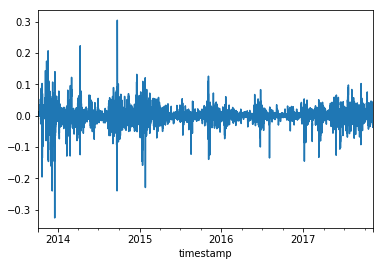

In [7]:
# preprocess: logarithm and ewma
df['price'] = np.log(df['price'])
df['volume'] = np.log(df['volume'])
df['open'] = np.log(df['open'])
df['high'] = np.log(df['high'])
df['low'] = np.log(df['low'])
df['close'] = np.log(df['close'])
ewma = df.ewm(halflife=7).mean()
df = df - ewma

df['price'].plot()

features = len(df.columns)
print('Data has got % features' % (features))

dataset = df.values

In [8]:
# split into train and test sets
train, test = dataset[0:-50,:], dataset[-50:,:]

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_price.fit_transform(train[:,0].reshape(-1, 1))

array([[ 0.51711595],
       [ 0.51711595],
       [ 0.51711595],
       ..., 
       [ 0.50134742],
       [ 0.51270467],
       [ 0.50734059]])

In [10]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

In [ ]:
# create and load model
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features), stateful=True))
model.add(Dense(look_forward))
try:
    model.load_weights("model_forward.h5")
except:
    pass
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/1
 - 97s - loss: 0.0015
Train Score: 0.02953 RMSE
Test Score: 0.02749 RMSE


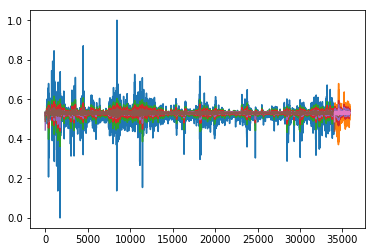

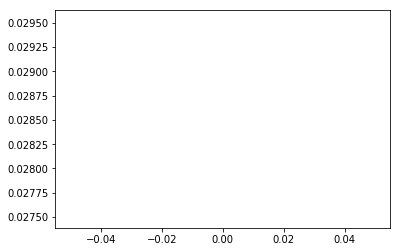

Epoch 1/1
 - 98s - loss: 6.4621e-04
Train Score: 0.02674 RMSE
Test Score: 0.02422 RMSE


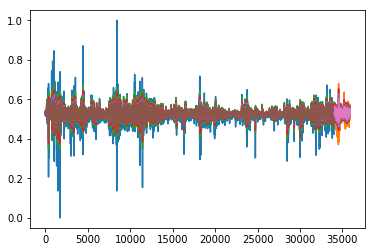

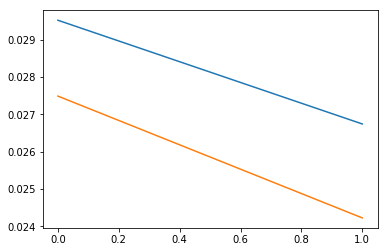

Epoch 1/1
 - 99s - loss: 6.0232e-04
Train Score: 0.02639 RMSE
Test Score: 0.02360 RMSE


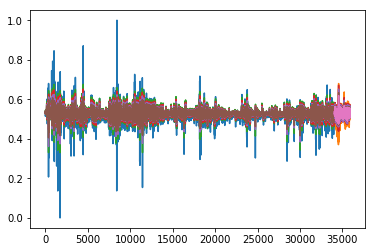

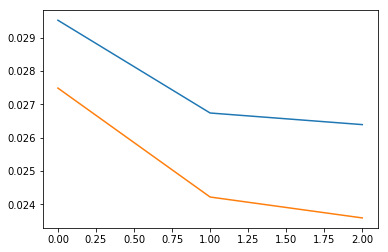

Epoch 1/1
 - 97s - loss: 6.0030e-04
Train Score: 0.02645 RMSE
Test Score: 0.02348 RMSE


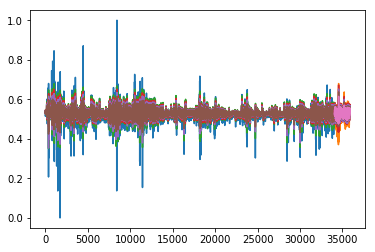

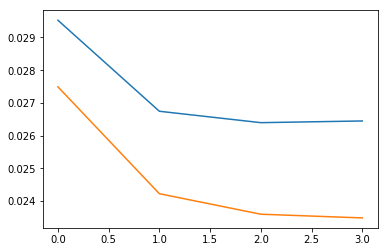

Epoch 1/1
 - 98s - loss: 5.9964e-04
Train Score: 0.02632 RMSE
Test Score: 0.02319 RMSE


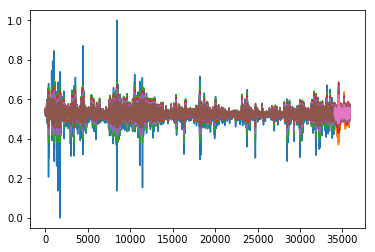

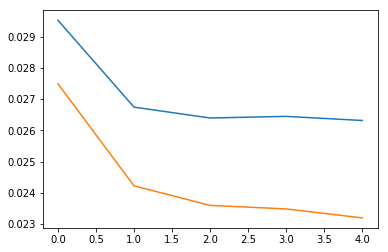

Epoch 1/1
 - 96s - loss: 5.9898e-04
Train Score: 0.02641 RMSE
Test Score: 0.02275 RMSE


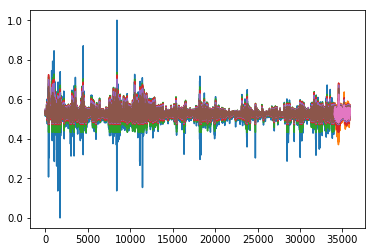

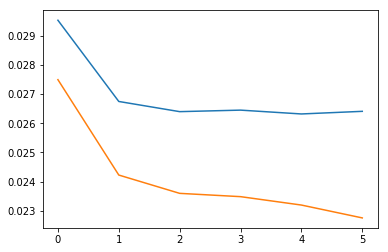

Epoch 1/1
 - 96s - loss: 5.9379e-04
Train Score: 0.02588 RMSE
Test Score: 0.02217 RMSE


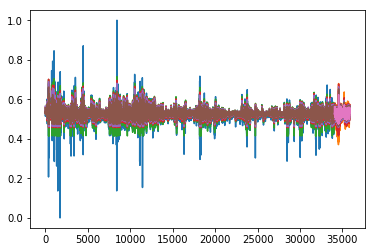

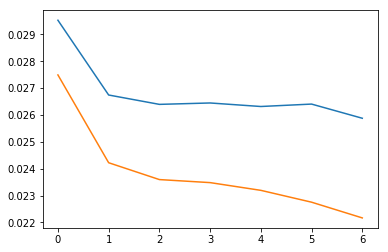

Epoch 1/1
 - 98s - loss: 5.8473e-04


In [ ]:
trainError = []
testError = []

for i in range(300):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    model.save_weights("model_buysell.h5")
    
    model_test = model
    
    # make predictions
    trainPredict = model_test.predict(trainX, batch_size=batch_size)
    model_test.reset_states()
    testPredict = model_test.predict(testX, batch_size=batch_size)

    trainPredict_t = scaler_price.inverse_transform(trainPredict)
    trainY_t = scaler_price.inverse_transform(trainY)
    testPredict_t = scaler_price.inverse_transform(testPredict)
    testY_t = scaler_price.inverse_transform(testY)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_t, trainPredict_t))
    trainError.append(trainScore)
    print('Train Score: %.5f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_t, testPredict_t))
    testError.append(testScore)
    print('Test Score: %.5f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainYPlot = np.empty_like(dataset)
    trainYPlot[:, :] = np.nan
    trainYPlot[look_back-1:len(trainPredict_t)+look_back-1,0] = trainY_t[:,0]
    # shift test predictions for plotting
    testYPlot = np.empty_like(dataset)
    testYPlot[:, :] = np.nan
    testYPlot[len(trainPredict_t)+look_back-1+look_forward:len(trainPredict_t)+look_back-1+look_forward+len(testPredict_t),0] = testY_t[:,0]
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back-1:len(trainPredict_t)+look_back-1,:look_forward] = trainPredict_t
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict_t)+look_back-1+look_forward:len(trainPredict_t)+look_back-1+look_forward+len(testPredict_t),:look_forward] = testPredict_t
    # plot baseline and predictions
    plt.plot(trainYPlot)
    plt.plot(testYPlot)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    plt.plot(trainError)
    plt.plot(testError)
    plt.show()

In [ ]:
print(trainYPlot.shape)
print(trainPredictPlot.shape)
print(testYPlot.shape)
print(testPredictPlot.shape)


for i in range(look_forward): 
    trainYPlot[:,i] = np.exp(trainYPlot[:,i]+ewma['price'])
    testYPlot[:,i] = np.exp(testYPlot[:,i]+ewma['price'])
    trainPredictPlot[:,i] = np.exp(trainPredictPlot[:,i]+ewma['price'])
    testPredictPlot[:,i] = np.exp(testPredictPlot[:,i]+ewma['price'])

# print(trainYPlot)
# print(trainPredictPlot)
# print(testYPlot)
# print(testPredictPlot)



import matplotlib

matplotlib.rcParams['figure.figsize'] = (18,16)
# plt.plot(trainYPlot2['price'])
# plt.plot(testYPlot2['price'])
# plt.plot(trainPredictPlot2['price'])
# plt.plot(testPredictPlot2['price'])
# plt.plot(trainYPlot2['price'] - trainPredictPlot2['price'])
# plt.plot(testYPlot2['price'] - testPredictPlot2['price'])
# plt.show()


plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,0])
plt.plot(testYPlot[:,0] - testPredictPlot[:,0])
plt.show()

plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,1])
plt.plot(testYPlot[:,1] - testPredictPlot[:,1])
plt.show()

plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,2])
plt.plot(testYPlot[:,2] - testPredictPlot[:,2])
plt.show()

trainYError = trainYPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
trainPredictError = trainPredictPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
testYError = testYPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
testPredictError = testPredictPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYError, trainPredictError))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYError, testPredictError))
print('Test Score: %.5f RMSE' % (testScore))

for i in range(look_forward):
    print('Test Score %: %.5f RMSE' % (i, math.sqrt(mean_squared_error(testYError[:,i], testPredictError[:,i]))))